# Basic MCMC

Making the plot of markov chain walker, explaination

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jax import random, grad
import jax.numpy as jnp

sns.set_style('whitegrid')


1.0


Text(0.5, 0.92, 'Wireframe')

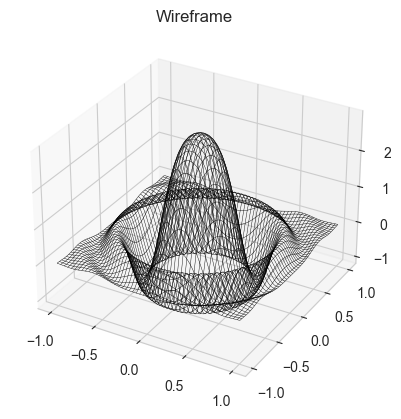

In [107]:
# Making a monte carlo optimiser for a function

def complexf1(x,y):
    return ((x*jnp.sin(5*y)+y*jnp.sin(5*x))**2)*(jnp.cosh(jnp.sin(10*x)*x)) + ((x*jnp.cos(5*y)-y*jnp.sin(5*x))**2)*(jnp.cosh(jnp.cos(20*y)*y))
def complexf2(x,y):
    return ((x*jnp.sin(20*y)+y*jnp.sin(20*x))**2)*(jnp.cosh(jnp.sin(10*x)*x)) + ((x*jnp.cos(10*y)-y*jnp.sin(10*x))**2)*(jnp.cosh(jnp.cos(20*y)*y))
def simplef1(x,y):
    return 3*jnp.cos(((3*x)**2+(3*y)**2))*jnp.exp(-3*(x**2+y**2))
def simplef2(x,y):
    return 3*jnp.cos(((3*x)**2+(3*y)**2))*jnp.exp(-0.1*(x+y)) + ((x*jnp.sin(5*y)+y*jnp.sin(5*x))**2)*(jnp.cosh(jnp.sin(10*x)*x))

print(jnp.cos(0.0))

x = jnp.linspace(-1,1,200)
y = jnp.linspace(-1,1,200)
X,Y = jnp.meshgrid(x,y)
Z = simplef1(X,Y)

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_wireframe(X,Y,Z,color = 'black', lw = 0.3)
ax.set_title('Wireframe')

Text(0.5, 0.92, 'Monte Carlo Walk')

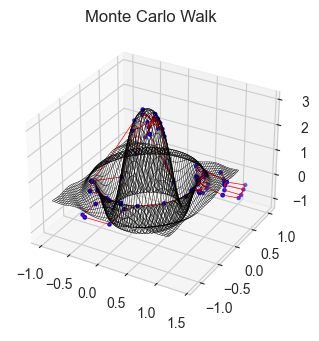

In [149]:
# Doing monte carlo optimisation on this function:-
x0 = 0.8; y0 = 0.8
n = 200

def monte_carlo_walk(fun, x0, y0, n, bounds = (np.array([-2,2]) ,np.array([-2,2])) ):
    xs = np.zeros(n); ys = np.zeros(n)
    for i in range(n):
        x1 = 0.2*random.normal(random.PRNGKey(i),shape = (1,)) + x0
        y1 = 0.2*random.normal(random.PRNGKey(i+1),shape = (1,)) + y0
        if (x1 < bounds[0][0]) or (x1 > bounds[0][1]) or (y1 < bounds[1][0]) or (y1 > bounds[1][1]):
            x1 = x0
            y1 = y0
            i = i-1
            continue
        if fun(x1,y1) > fun(x0,y0):
            x0 = x1
            y0 = y1
        else:
            flip = random.uniform(random.PRNGKey(i+2),shape = (1,))
            if flip < fun(x1,y1)/fun(x0,y0):
                x0 = x1
                y0 = y1
            else:
                x0 = x0
                y0 = y0
        xs[i] = x0; ys[i] = y0
    return xs, ys

fig = plt.figure()
xs, ys = monte_carlo_walk(simplef1, x0, y0, n)
ax = plt.axes(projection = '3d')
ax.plot_wireframe(X,Y,Z,color = 'black', lw = 0.3)
ax.scatter(xs,ys,simplef1(xs,ys),color = 'blue',s = 5)
ax.plot(xs,ys,simplef1(xs,ys),color = 'red',lw = 0.5)
ax.set_title('Monte Carlo Walk')

# Try to add slider, which actually works on jupyter book

Note on why gradient descent fails here,
Then take 10000 points and show that almost same histogram has been made

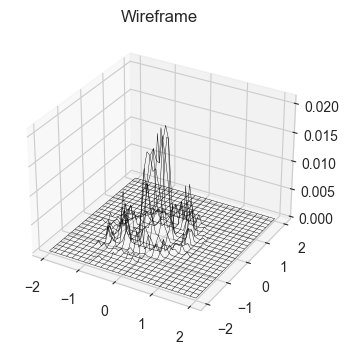

In [152]:
xs, ys = monte_carlo_walk(simplef1, x0, y0, 10000)

def plot3dhist(xs, ys, starts, ends, bins):
    z_hist = np.zeros((bins[0]+1, bins[1]+1))
    for i in range(len(xs)):
        z_hist[int((xs[i]-starts[0])/(ends[0]-starts[0])*bins[0])-1, int((ys[i]-starts[1])/(ends[1]-starts[1])*bins[1])-1] += 1

    x = jnp.linspace(starts[0],ends[0], bins[0]+1)
    y = jnp.linspace(starts[1],ends[1], bins[1]+1)
    X,Y = jnp.meshgrid(x,y)
    Z = z_hist/len(xs)
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.plot_wireframe(X,Y,Z,color = 'black', lw = 0.3)
    ax.set_title('Wireframe')
    plt.show()

# plot3dhist(xs[5000:9999],ys[5000:9999],[-2,-2],[2,2],(50,50))
plot3dhist(xs,ys,[-2,-2],[2,2],(50,50))

This took almost 20 s to run on my computer, for such a simple implementation (although it uses a lot of for loop). This makes us appreciate how much powerful our methods have to be if we have to work on complex distributions with thousands of parameters and many complicated priors.

Make a good function named danger function which we can use in other demonstrations also

In [110]:
# Let us do this using gradient descent
def simplef12(w):
    x = w[0]; y = w[1]
    return 3*jnp.cos(((3*x)**2+(3*y)**2))*jnp.exp(-3*(x**2+y**2))

gradient = grad(simplef12)(jnp.array([0.8,0.8]))
print(gradient)

[0.6487649 0.6487649]


Basic markov chains